In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.notebook import trange, tqdm
import os
import copy
import datetime
import ntpath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from scipy import signal
import pywt
import pandas as pd
import mne
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os, sys

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

torch.manual_seed(11)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


# 1.) Compute preds for Validation Set

In [ ]:

#testing lr =0.000925 280 ep
#training batchsize
batch_size = 10

learning_rate =0.001

weight_decay = 0.1

#Only if using SGD
momentum = 0.0005

#choose number of epochs
num_epochs = 85

#beta value for multiplicative loss
beta = 0.92

#delta value for boosted fusion loss
delta = 10.0

#path to training set. ex: train_path = "~/SMNI_TRAINTEST_DATA/"
data_dir= 'gdrive/Shared drives/Wave_LEMON/datasets/1sec_seg_training_class_fif_1800'

#save model?
save = False
#ex: "save_as = <fileName>.pt" or "save_as = <fileName>.pth"
save_as = "conv2d_by_Leads_1_copy"

#load wts from torch.nn.Module.load_state_dict for "model"?
load_wts = False

#path torch.nn.Module.load_state_dict for "model"
path_wts = "gdrive/Shared drives/Wave_LEMON/boosted_fusion_1800= 0.92r=0.0001_wd=0.3_ep=33_acc=0.9178 (1).tar"

## Dataset and DataLoader 1sec window
configured for 26 patient

In [ ]:
class HiddenPrints:
    """
    Helper class to suppress mne print statements
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
#I changed the dataloader to an updated version.
class Wavelet_Dataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.samples = self.make_dataset(root_dir, ".fif")
        self.transform = transform

    def make_dataset(self, dir , extensions):
        """creates a list of paths to data in root data directory

        Args:
            dir: path to data directory of train/val datafiles i.e. ~/SMNI_TRAINTEST_DATA/train
            class_to_index

        Returns:
            list: images list of pats to data
        """

        images = []

        for root, _, fnames in sorted(os.walk(dir)):
            for fname in sorted(fnames):
                if self.has_file_allowed_extension(fname, ".fif"):
                    path = os.path.join(root, fname)
                    cls = -1
                    if fname.split('_')[2] == "mild":
                        cls = 0
                    elif fname.split('_')[2] == "moderate":
                        cls = 1
                    elif fname.split('_')[2] == "severe":
                        cls = 2

                    item = (path,cls)
                    #print(item)
                    images.append(item)

        return images

    def Wavelet(self,path:str):
        """
        create data cubes using data from .csv file at path. of the form <
        (Lead)x(frequencies)x(time) Power wavelete data types.

        Args:
            path to .csv file (should be passed by TesseractData and dataset)
            ex: ~/SMNI_TRAINTEST_DATA/train/alcoholic/a_S3_377_069.csv

        Returns: tess 3D numpy array containing time frequency transform data
                 of shape (Lead)x(frequency)x(time).
        """
        channels = 61
        scale = 32 #scale param for morle wavelet
        length = 250

        with HiddenPrints():
            raw = mne.io.read_raw_fif(path)
        raw = raw.get_data(picks=raw.ch_names, start=0)

        data = pd.DataFrame(data=raw)

        y_voltage = np.empty([channels, length])
        for i in range(channels):
            y_voltage[i] = data.iloc[i]


        # Generate a 3d array of channelXfreqXtime
        waves_mag = np.empty([61, scale, 250 ], dtype=float) 
        # store the abs(coef) into waves_mag instead of computing waves_cmp
        # then taking the absolute value of waves_cmp. I hope this speeds things up

        # compute and store complex morlet transform for each lead
        # THIS VERSION PUTS Lead First
        for i in range(channels):
            coef, freqs=pywt.cwt(y_voltage[i],np.arange(1,scale+1),'cmor0.4-1.0',sampling_period=1)
            waves_mag[i,:,:] = copy.deepcopy(abs(coef))

        return waves_mag
        
    def has_file_allowed_extension(self, filename, extensions):
        """Generic file extension checker. does

        Args:
            filename (string): path to a file

        Returns:
            bool: True if the filename ends with a known image extension
        """
        filename_lower = filename.lower()
        return any(filename_lower.endswith(ext) for ext in extensions)
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (tesseractTransform(sample(index), target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.Wavelet(path)
        sample = np.array(sample).astype(np.float64)
        sample = torch.FloatTensor(sample)
        
        if self.transform:
            sample = self.transform(sample)

        return sample, target
    
    def __len__(self):
        return len(self.samples)

In [ ]:
def wavelet_collate(batch):
    """
    custom collate function for turning a batch of wavelet data types into 
    (batch_size)x300x32x256 TENSORS
    
    Args:
        Batch: batch of Wavelet Data tensors
    
    Returns:
        tuple: (Wavelet_Dataset(sample(index)), target) where target is class_index of the target class.
    """
    data = torch.stack([item[0] for item in batch])  # just form a tensor
    #target = torch.stack([item[1] for item in batch])
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

#data loader
def wavelet_dataloader(dataset, batch_size: int, shuffle=False):
    """
    Custom data loader returns DataLoader of Wavelet_Dataset types
    
    Args:
        root: path to data. ex: ~/SMNI_TRAINTEST_DATA/train/
        batch_size: batch size
        shuffle: shuffle data
    Returns:
        Dataloader with time Wavelet_Dataset data
    """
    return DataLoader(dataset=dataset, batch_size=batch_size,collate_fn=wavelet_collate,shuffle=shuffle, num_workers=0, pin_memory=True)

In [ ]:
mean = [5.7504194894601505e-06,
5.728741585181514e-06,
7.237039053965088e-06,
4.208074243624845e-06,
2.50056270944241e-06,
4.187197870766758e-06,
7.32017148665085e-06,
6.439270389808919e-06,
2.1467175120274207e-06,
2.3475471417550127e-06,
6.92765799823113e-06,
9.373363941055193e-06,
6.720977282804776e-06,
3.654530031713957e-06,
7.354775270897619e-06,
1.005174847817515e-05,
1.0398115199924857e-05,
8.134736021888628e-06,
8.589935443835935e-06,
1.1703290203058822e-05,
4.1053606566116706e-06,
1.4658332241735504e-05,
1.2955417495042837e-05,
1.2311520129481097e-05,
1.3715734581283254e-05,
1.718611863764373e-05,
1.6169887774143943e-05,
1.8119934887564533e-05,
1.673298069550639e-05,
1.819891762772844e-05,
1.6308829853755876e-05,
6.48752313737657e-06,
4.570791071775696e-06,
4.532000651713432e-06,
6.532488790511118e-06,
5.464546367466236e-06,
2.919301209624429e-06,
3.0568041456318864e-06,
5.3192569407745355e-06,
8.227752725951735e-06,
4.358965567117618e-06,
4.794040174267047e-06,
8.304855411561447e-06,
8.112487818368185e-06,
4.633563600870139e-06,
5.087105051877014e-06,
8.74617345446718e-06,
1.1613653614248209e-05,
9.39294167273587e-06,
7.921913058602362e-06,
1.0266379722641722e-05,
1.3078571988562245e-05,
1.3931141269894663e-05,
1.1994570612201592e-05,
1.2464052821413853e-05,
1.5985735642926502e-05,
1.8228924335767787e-05,
1.678402784160463e-05,
1.608585899584544e-05,
1.713535016683776e-05,
2.011528695302471e-05]

dev = [6.057284722117714e-06,
5.955594623062248e-06,
7.51299863285755e-06,
4.28137984287368e-06,
2.7263079414823437e-06,
4.270560061930021e-06,
7.623474677409314e-06,
6.871208281970108e-06,
2.1786990922699215e-06,
2.404251273737509e-06,
7.372362604591492e-06,
1.0225397268429354e-05,
7.810197348585481e-06,
4.3948422182336315e-06,
8.45789340116696e-06,
1.1624432890069268e-05,
1.2439505171691405e-05,
1.0217743960394727e-05,
1.0762761009416062e-05,
1.4475259894639832e-05,
4.416342590595693e-06,
1.873906338603034e-05,
1.654761534279868e-05,
1.5858310351588178e-05,
1.7443518418910416e-05,
2.246008604131442e-05,
2.1030259718298304e-05,
2.4856477995226744e-05,
2.1501386127451786e-05,
2.4235498658256147e-05,
2.109854948315952e-05,
6.702665391715863e-06,
4.824524504629907e-06,
4.7471229608639915e-06,
6.699013264300426e-06,
5.880738444313614e-06,
3.0474061729009764e-06,
3.285427320028878e-06,
5.3602471609911775e-06,
8.954077171320513e-06,
4.57610275169536e-06,
4.947610111168858e-06,
8.976876550005724e-06,
9.08240022985891e-06,
6.068825347797623e-06,
6.078034066110466e-06,
1.0175379250455029e-05,
1.3681107179448334e-05,
1.1456005937018132e-05,
1.0202288960524899e-05,
1.27642286872347e-05,
1.6238574252936906e-05,
1.7985560336626746e-05,
1.538079346285363e-05,
1.5763985162523097e-05,
2.0444270837946755e-05,
2.532880438342928e-05,
2.229767554392438e-05,
2.0638056594009807e-05,
2.1945532436029406e-05,
2.7350538859202916e-05]

In [ ]:

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=mean,std=dev)
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=mean,std=dev)
    ]),
}


In [ ]:
#Lemon_train_dataset = TesseractData(os.path.join(data_dir, 'train'))
dataset = {x: Wavelet_Dataset(os.path.join(data_dir, x),transform=data_transforms[x]) for x in ['train', 'val']}
 
#set to train w/ GPU if available else cpu
data_loaders_dict = {x: wavelet_dataloader(dataset[x], batch_size = batch_size, shuffle=True) for x in ['train', 'val']}
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

In [ ]:
class Wave_Lead_Conv(nn.Module):
    """
    Wave_Lead_Conv is a convolution model designed to convolve over a single scaleogram,
    of shape (1,freq,time) generated by one EEG lead. this model is the portion of 
    onv2d_by_Leads model without the last linear layer that combines the output for each
    lead.
    """
    def __init__(self):
        super(Wave_Lead_Conv,self).__init__()
            
        self.conv1 = nn.Conv2d(1,8, kernel_size=(3,4), stride=(1,2), padding=(1,2)) 
        self.maxPool1 = nn.MaxPool2d((2,2))
      
        self.conv2 = nn.Conv2d(8,16, kernel_size=(4,3), stride=(2,2), padding=1)
        self.maxPool2 = nn.MaxPool2d((2,2))
        
        
        self.conv3 = nn.Conv2d(16,32, kernel_size=(3,4), stride=(1,2), padding=1)
        self.maxPool3 = nn.MaxPool2d((2,2))
        #self.conv3_bn = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32,64, kernel_size=(2,4), stride=(1,1))
        #self.conv4_bn = nn.BatchNorm2d(64)
        
        self.dropout = nn.Dropout(p=0.50)
        self.fc1 = nn.Linear(64,3) 
   
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self,x):
        #import pdb; pdb.set_trace()
        #convolve over channels only
        x = self.conv1(x)
        x = self.maxPool1(x)
        #x = self.conv1_bn(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = self.maxPool2(x)
        #x = self.conv2_bn(x)
        x = torch.relu(x)
        
        x = self.conv3(x)
        x = self.maxPool3(x)
        #x = self.conv3_bn(x)
        x = torch.relu(x)
        
        x = self.conv4(x)
        #x = self.conv4_bn(x)
        
        x = self.dropout(x)
        x = x.view(64)
        x = self.fc1(x) 
        x = self.softmax(x)
        #print(x)
        return x

In [ ]:
class Wave_Fusion_Model(nn.Module):
    """
    Wave Fusion Model. Contains 64 Wave Lead Convs that convolves over each 
    eeg Lead. Implements multiplicative fusion loss by Liu
    et al https://arxiv.org/pdf/1805.11730.pdf
    """
    def __init__(self, beta):
        self.leads = 61
        self.beta = beta
        super(Wave_Fusion_Model,self).__init__()
        for i in range(self.leads):
            self.add_module('Wave_Lead_Conv' + str(i), Wave_Lead_Conv())
        self.Wave_Lead_Conv = AttrProxy(self, 'Wave_Lead_Conv')



    def forward(self, x):
        """
        feeds each eeg channel in x to a Wave_Lead_Conv
        x: a tensor of shape BatchSize x self.leads x 32 x 256
        returns: 
        On training: a list of size (batchsize, num_lead) w/ each entry a [1,2] tensor of softmax probabilities for each class
        On eval: a tensor containing the class losses for each data in the batch
        """
        tmp = []
        preds = []
        bs = len(x[:,0,0,0])

        #feed data to the Wave_Lead_Convs and return list of predictions
        for i in range(bs):
            tmp = []
            for j in range(self.leads):
                #each lead to a wave_lead_conv. reshape to 1,1,32,250
                #print(x[i,j,:,:].shape)
                t1 = self.Wave_Lead_Conv.__getitem__(j)(x[i,j,:,:].view(1,1,32,250))
                t1 = t1.clone()
                #t1.retain_grad()
                tmp.append(t1)
            
            preds.append(tmp)
        #training prediction is a list of size (batchsize, num_lead) w/ each entry a [1,2] tensor of softmax probabilities for each class
        if self.training:
            return preds
        #eval predictions are the loss for each class. 
        else:

            #Liu Method
            pred_tmp = []
            for i in range(bs):
                loss0 = 0
                loss1 = 0
                loss2 = 0
                coeff0 = []
                coeff1 = []
                coeff2 = []


                #compute the class loss0
                for j in range(self.leads):
                    #if preds[i][j][0] != 1 and preds[i][j][0] != 0: 
                    #compute weighting coefficient
                    coeff = 1
                    for k in range(self.leads):

                        if k != j:
                            coeff = coeff * (1-preds[i][k][0])

                    #detach coefficient from computation graph
                    coeff=coeff.detach()
                    coeff0.append(coeff)
                    #calculate loss, add
                    loss0 += (-1.0)*torch.pow( coeff, beta/(self.leads-1) )*torch.log(preds[i][j][0])
                    
                    #loss0 += (-1.0)*torch.log(preds[i][j][0])
                
                #calculate class loss 1
                for j in range(self.leads):
                    
                    #if preds[i][j][1] != 1 and preds[i][j][1] != 0:
                    #compute weighting coefficient
                    coeff = 1
                    for k in range(self.leads):
                        if k != j:
                            coeff = coeff * (1-preds[i][k][1])

                    #detach coefficient from computation graph
                    coeff=coeff.detach()
                    coeff1.append(coeff)

                    #calculate loss, add
                    loss1 += (-1.0)*torch.pow( coeff, beta/(self.leads-1) )*torch.log(preds[i][j][1])
                    
                    #loss1 += (-1.0)*torch.log(preds[i][j][1])
                    
                #calculate class loss 2
                for j in range(self.leads):
                    
                    #if preds[i][j][1] != 1 and preds[i][j][1] != 0:
                    #compute weighting coefficient
                    coeff = 1
                    for k in range(self.leads):
                        if k != j:
                            coeff = coeff * (1-preds[i][k][2])

                    #detach coefficient from computation graph
                    coeff=coeff.detach()
                    coeff2.append(coeff)

                    #calculate loss, add
                    loss2 += (-1.0)*torch.pow( coeff, beta/(self.leads-1) )*torch.log(preds[i][j][2])
                    
                    #loss1 += (-1.0)*torch.log(preds[i][j][1])
                
                
                
                
                
                
                
                #combine losses into 1x3 tensor
                tmp = torch.stack((loss0,loss1,loss2), 0)

                #combine coefficients for each prediction into 1x61 tensors

                coeff0 = torch.FloatTensor(coeff0)
                coeff1 = torch.FloatTensor(coeff1)
                coeff2 = torch.FloatTensor(coeff2)
                #print(coeff0.shape)
                #print(coeff1.shape)
                #print(coeff2.shape)

                coeffs = torch.stack((coeff0,coeff1,coeff2))
                #combine 1x61 tensors into bs 
                #add preds to lest
                pred_tmp.append(tmp)
            
            #stack all losses together as tensor
            preds = torch.stack(pred_tmp)
            
            return preds, coeffs


class AttrProxy(object):
    """indexes Wave_Lead_Conv models as Wave_Lead_Conv0, Wave_Lead_Conv1,...
    Wave_Lead_Conv63  in the Wave_Fusion_Model."""
    def __init__(self, module, prefix):
        """
        args:
            module: the Wave_Lead_Conv component to be named
            prefix: int
        """
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        """retrieves the ith Wave_Lead_Conv from Wave_Fusion_Model."""
        return getattr(self.module, self.prefix + str(i))

In [ ]:
#set to train w/ GPU if available else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Wave_Fusion_Model(beta = beta).to(device)

cuda:0


In [ ]:
checkpoint = torch.load( "gdrive/Shared drives/Wave_LEMON/models/boosted_fusion_1800= 0.92r=0.0001_wd=0.3_ep=33_acc=0.9178 (1).tar")
model.load_state_dict(checkpoint['model_state_dict'])
#optim.load_state_dict(checkpoint['optimizer_state_dict'])
best_acc = checkpoint['acc']
print(best_acc)

0.9178


# Create Coefficient Interpolation Plots
Computed for three examples

In [ ]:
chan_names = ['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'AFz',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10',
 'AF7',
 'AF3',
 'AF4',
 'AF8',
 'F5',
 'F1',
 'F2',
 'F6',
 'FT7',
 'FC3',
 'FC4',
 'FT8',
 'C5',
 'C1',
 'C2',
 'C6',
 'TP7',
 'CP3',
 'CPz',
 'CP4',
 'TP8',
 'P5',
 'P1',
 'P2',
 'P6',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8']

In [ ]:
def Wavelet(path:str):
    """
    create data cubes using data from .csv file at path. of the form <
    (Lead)x(frequencies)x(time) Power wavelete data types.

    Args:
        path to .csv file (should be passed by TesseractData and dataset)
        ex: ~/SMNI_TRAINTEST_DATA/train/alcoholic/a_S3_377_069.csv

    Returns: tess 3D numpy array containing time frequency transform data
                of shape (Lead)x(frequency)x(time).
    """
    channels = 61
    scale = 32 #scale param for morle wavelet
    length = 250

    with HiddenPrints():
        raw = mne.io.read_raw_fif(path)
    raw = raw.get_data(picks=raw.ch_names, start=0)

    data = pd.DataFrame(data=raw)

    y_voltage = np.empty([channels, length])
    for i in range(channels):
        y_voltage[i] = data.iloc[i]


    # Generate a 3d array of channelXfreqXtime
    waves_mag = np.empty([61, scale, 250 ], dtype=float) 
    # store the abs(coef) into waves_mag instead of computing waves_cmp
    # then taking the absolute value of waves_cmp. I hope this speeds things up

    # compute and store complex morlet transform for each lead
    # THIS VERSION PUTS Lead First
    for i in range(channels):
        coef, freqs=pywt.cwt(y_voltage[i],np.arange(1,scale+1),'cmor0.4-1.0',sampling_period=1)
        waves_mag[i,:,:] = copy.deepcopy(abs(coef))
        print(freqs)

    return waves_mag

In [ ]:
def preprocess_image(path, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    ten = torch.FloatTensor(Wavelet(path))
    ten = data_transforms['val'](ten)
    return ten.unsqueeze(0).to(device)

In [ ]:
wmild = preprocess_image('input_images/sub-032320_EC_mild_1_raw.fif')
wmoderate = preprocess_image('input_/sub-032464_EC_moderate_75_raw.fif')
wsevere =  preprocess_image('gdrive/Shared drives/Wave_LEMON/datasets/1sec_seg_training_class_fif_1800/val/severe/sub-032455_EC_severe_101_raw.fif')

[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
 0.04       0.03846154 0.03703704 0.03571429 0.03448276 0.03333333
 0.03225806 0.03125   ]
[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
 0.04       0.03846154 0.03703704 0.03571429 0.03448276 0.03333333
 0.03225806 0.03125   ]
[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
 0.04       0.

In [ ]:
model.eval()
_, mild_coeffs = model(wmild)
_, mod_coeffs = model(wmoderate)
_, sev_coeffs = model(wsevere)



In [ ]:
# Create mild activations
mildex_act = np.array(mild_coeffs[0])
mildex_act =  np.expand_dims(mildex_act, axis=1)

# Create moderate activations
modex_act = np.array(mod_coeffs[0])
modex_act =  np.expand_dims(modex_act, axis=1)

# Create severe activations
sev_act = np.array(sev_coeffs[0])
sev_act =  np.expand_dims(sev_act, axis=1)

In [ ]:
# Definition of channel types and names.
ch_types = ['EEG']
ch_names = chan_names
sfreq = 250

In [ ]:
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg']*61)

In [ ]:
# Create mne objects for interpolation
mild_raw = mne.io.RawArray(mildex_act , info) 
mod_raw = mne.io.RawArray(modex_act , info) 
sev_raw = mne.io.RawArray(sev_act, info)

Creating RawArray with float64 data, n_channels=61, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Creating RawArray with float64 data, n_channels=61, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Creating RawArray with float64 data, n_channels=61, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [ ]:
#set montages
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print("Setting montage...")
print(ten_twenty_montage)
mild_raw.set_montage(ten_twenty_montage)
mod_raw.set_montage(ten_twenty_montage)
sev_raw.set_montage(ten_twenty_montage)

Setting montage...
<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


<RawArray | 61 x 1 (0.0 s), ~167 kB, data loaded>

In [ ]:
raw = mne.io.read_raw_fif('gdrive/Shared drives/Wave_LEMON/datasets/1sec_seg_training_class_fif_1800/val/moderate/sub-032464_EC_moderate_75_raw.fif')

Opening raw data file gdrive/Shared drives/Wave_LEMON/datasets/1sec_seg_training_class_fif_1800/val/moderate/sub-032464_EC_moderate_75_raw.fif...
    Range : 18750 ... 18999 =     75.000 ...    75.996 secs
Ready.


In [ ]:
raw.info['dig'].insert(0,mod_raw.info['dig'][0:3])

In [ ]:
type(mod_raw.info['dig'][0:3])

list

In [ ]:
mod_raw.info['dig']

[<DigPoint |        LPA : (-82.5, -0.0, 0.0) mm     : head frame>,
 <DigPoint |     Nasion : (0.0, 102.7, 0.0) mm      : head frame>,
 <DigPoint |        RPA : (82.2, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     EEG #1 : (-28.2, 102.3, 31.7) mm   : head frame>,
 <DigPoint |     EEG #3 : (28.6, 103.2, 31.6) mm    : head frame>,
 <DigPoint |     EEG #5 : (-52.6, 87.3, 29.4) mm    : head frame>,
 <DigPoint |     EEG #7 : (-32.3, 97.5, 59.2) mm    : head frame>,
 <DigPoint |     EEG #9 : (0.2, 102.3, 72.5) mm     : head frame>,
 <DigPoint |    EEG #11 : (34.2, 98.4, 59.9) mm     : head frame>,
 <DigPoint |    EEG #13 : (53.4, 88.4, 29.2) mm     : head frame>,
 <DigPoint |    EEG #16 : (-67.4, 62.3, 30.5) mm    : head frame>,
 <DigPoint |    EEG #17 : (-61.8, 69.7, 57.2) mm    : head frame>,
 <DigPoint |    EEG #18 : (-48.2, 76.3, 80.9) mm    : head frame>,
 <DigPoint |    EEG #19 : (-26.4, 81.3, 98.0) mm    : head frame>,
 <DigPoint |    EEG #20 : (0.3, 83.3, 103.8) mm     : head fra

In [ ]:
for i in reversed(mod_raw.info['dig'][0:3]):
    print(i)
    raw.info['dig'].insert(0,i)

<DigPoint |        RPA : (82.2, 0.0, 0.0) mm       : head frame>
<DigPoint |     Nasion : (0.0, 102.7, 0.0) mm      : head frame>
<DigPoint |        LPA : (-82.5, -0.0, 0.0) mm     : head frame>


In [ ]:
raw.info['dig']

[<DigPoint |        LPA : (-82.5, -0.0, 0.0) mm     : head frame>,
 <DigPoint |     Nasion : (0.0, 102.7, 0.0) mm      : head frame>,
 <DigPoint |        RPA : (82.2, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     EEG #1 : (-31482.8, 76152.8, 20846.8) mm : head frame>,
 <DigPoint |     EEG #2 : (31482.8, 76152.8, 20846.8) mm : head frame>,
 <DigPoint |     EEG #3 : (-49709.4, 68691.1, -5958.9) mm : head frame>,
 <DigPoint |     EEG #4 : (49668.9, 68720.9, -5953.0) mm : head frame>,
 <DigPoint |     EEG #5 : (0.0, 79025.5, 31304.4) mm : head frame>,
 <DigPoint |     EEG #6 : (-34537.4, 0.0, 77667.0) mm : head frame>,
 <DigPoint |     EEG #7 : (34609.2, 0.0, 77635.1) mm : head frame>,
 <DigPoint |     EEG #8 : (-63171.3, 0.0, 56871.7) mm : head frame>,
 <DigPoint |     EEG #9 : (63167.3, 0.0, 56876.1) mm : head frame>,
 <DigPoint |    EEG #10 : (-80831.5, 0.0, 26291.8) mm : head frame>,
 <DigPoint |    EEG #11 : (80831.5, 0.0, 26291.8) mm : head frame>,
 <DigPoint |    EEG #12 : (-32

In [ ]:
mod_raw.save('tst.fif', tmin=0, tmax=1,overwrite=True)

Overwriting existing file.
Writing /content/tst.fif
Closing /content/tst.fif [done]


<ipython-input-84-533e3e3a45a3>:1: RuntimeWarning: This filename (/content/tst.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  mod_raw.save('tst.fif', tmin=0, tmax=1,overwrite=True)


In [ ]:
# Create envoked response arrays
mild_evoked = mne.EvokedArray(mildex_act, mild_raw.info)
mod_evoked = mne.EvokedArray(modex_act, mod_raw.info)
sev_evoked = mne.EvokedArray(sev_act,sev_raw.info)

In [ ]:
mild_evoked.save("tst1_ave.fif")

In [ ]:
evokeds_list = mne.read_evokeds('tst1_ave.fif', baseline=(None, 0),
                                proj=True, verbose=False)

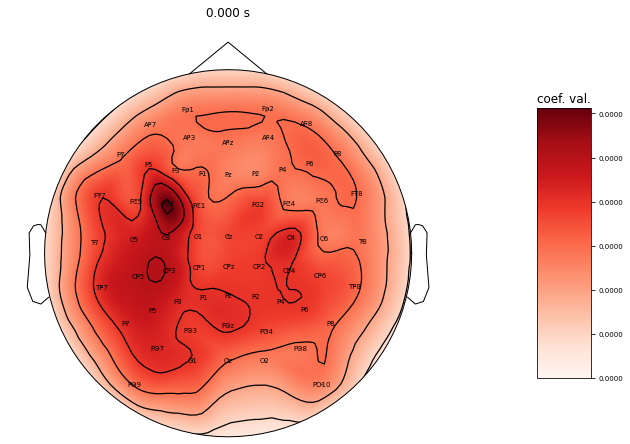

In [ ]:
extrapolations = ['head']
mild_evoked.plot_topomap(times=0, size=5,extrapolate='head',units='coef. val.',show_names=True,vmin=0.0,cbar_fmt='%.04f');
#ax.set_title('head', fontsize=14)
#fig, axes = plt.subplots(figsize=(7.5, 2.5))
extrapolations = ['head']


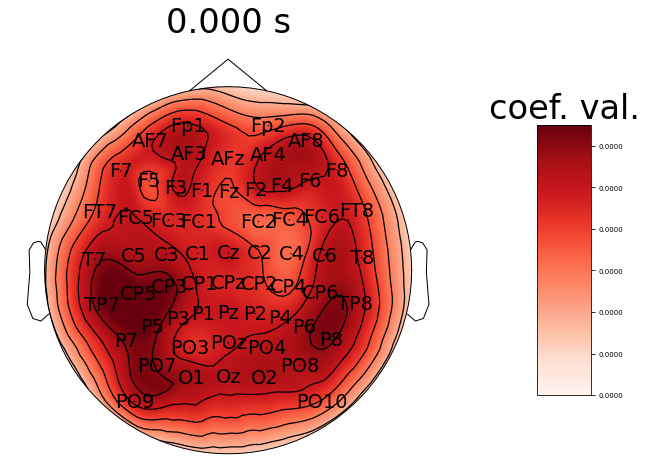

In [ ]:
extrapolations = ['head']
mod_evoked.plot_topomap(times=0, size=5,extrapolate='head',units='coef. val.',show_names=True,vmin=0.0,cbar_fmt='%.04f');
#ax.set_title('head', fontsize=14)
#fig, axes = plt.subplots(figsize=(7.5, 2.5))
extrapolations = ['head']

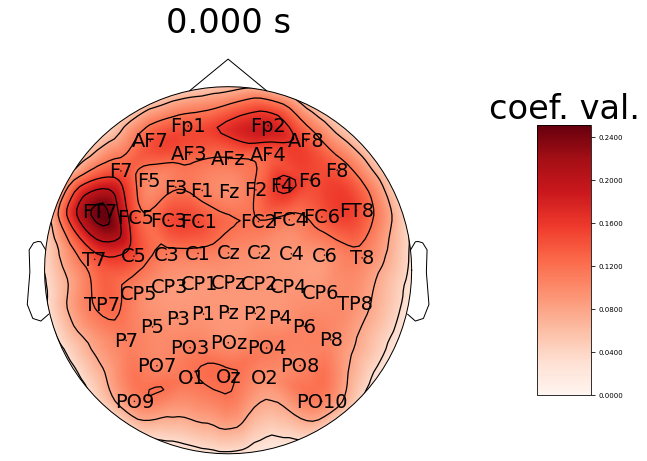

In [ ]:
extrapolations = ['head']
sev_evoked.plot_topomap(times=0, size=5,extrapolate='head',units='coef. val.',show_names=True,vmin=0.0,cbar_fmt='%.04f');
#ax.set_title('head', fontsize=14)
#fig, axes = plt.subplots(figsize=(7.5, 2.5))
extrapolations = ['head']

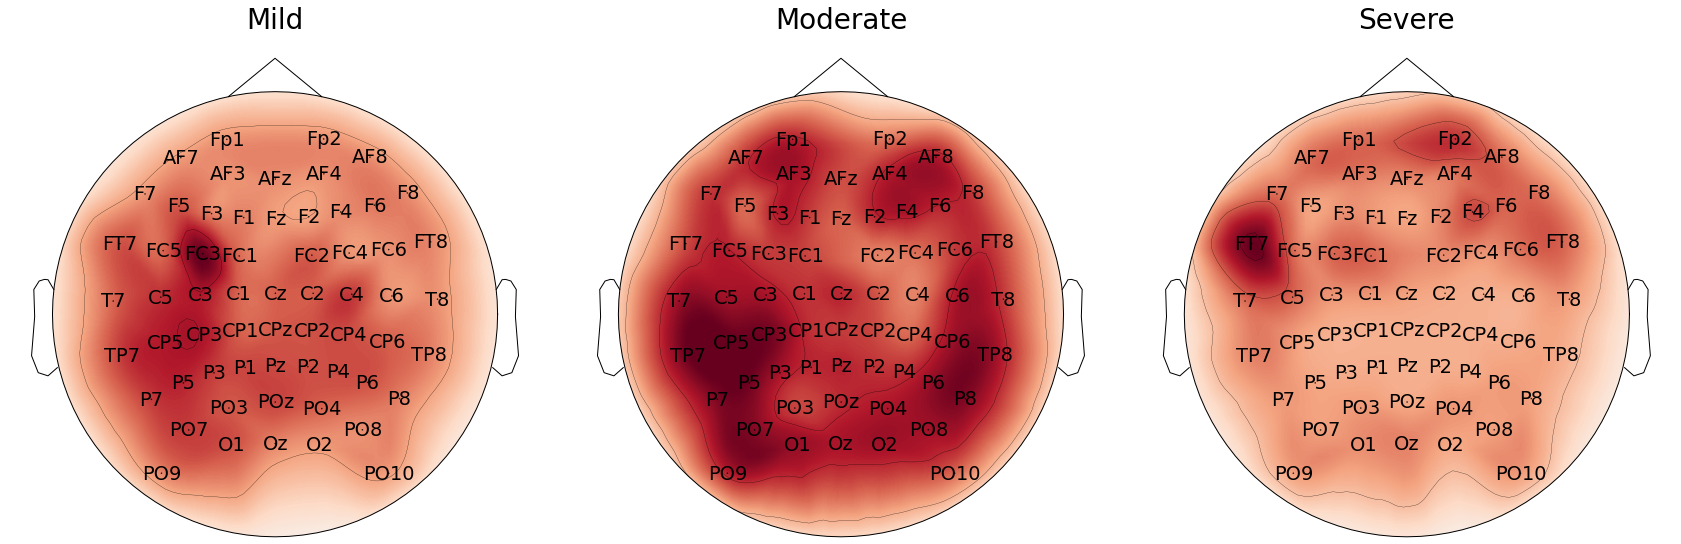

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
fig, axes = plt.subplots(figsize=(24, 8), nrows=1, ncols=3)
extrapolations = ['head']
mild_evoked.plot_topomap(times=0, extrapolate='head',units='mean act.',show_names=True,colorbar=False,axes=axes[0],show=False,sphere=(0., 0., 0., 0.09))
axes[0].set_title('Mild',  fontsize=28)
mod_evoked.plot_topomap(times=0, extrapolate='head',units='mean act.',show_names=True,colorbar=False,axes=axes[1],show=False, sphere=(0., 0., 0., 0.09))
axes[1].set_title('Moderate',  fontsize=28)
sev_evoked.plot_topomap(times=0, extrapolate='head',units='mean act.',show_names=True,colorbar=False,axes=axes[2],show=False, sphere=(0., 0., 0., 0.09))
axes[2].set_title('Severe',  fontsize=28)
fig.tight_layout()
fig.savefig('Wave_Fusion_interpolation.jpg')